In [245]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.svm import SVR
from statistics import mean
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import seaborn as sns
import xgboost as xgb
import pandas as pd
import arviz as az
import numpy as np
import arviz as az
import pymc as pm
import sqlite3
import joblib
import random 
import math
import os

In [246]:
col_order = ['Player', 'Team', 'Season', 'Age', 'G', 'PA', 'AB',
       'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB',
       'WAR', 'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs', 'Pos', 'status']

inactive_data = pd.read_csv('inactive_player_data.csv')
inactive_data = inactive_data[col_order]
active_data = pd.read_csv('new_active_player_data.csv')
active_data = active_data[col_order]

In [247]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,Pos,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,3.0,2.0,-0.7,0,0,0,0,0,9,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,5.0,0.0,2.0,0,0,0,0,0,8,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,3.0,3.0,2.6,1,0,0,1,0,8,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,2.0,1.0,2.5,0,0,0,0,0,8,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,12.0,2.0,3.3,0,0,0,0,0,8,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,9.0,3.0,2.2,0,1,0,0,0,6,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,6.0,4.0,1.5,0,0,0,0,0,6,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,5.0,7.0,4.3,1,1,0,0,0,6,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,7.0,12.0,5.6,1,1,0,0,0,6,retired


In [248]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,SF,IBB,WAR,GGs,SSs,Bat_Titles,All_Stars,MVPs,Pos,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,1,1,1.6,0,0,0,0,0,7,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,2,3,3.8,1,0,0,0,0,7,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,0,2,3.6,0,0,0,0,0,7,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,5,4,4.9,0,1,0,0,0,7,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,6,4,3.7,0,0,0,0,0,8,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,6,7,2.1,0,1,0,1,0,3,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,10,4,2.3,0,0,0,1,0,3,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,1,1,2.7,0,1,0,0,1,3,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,10,3,3.0,0,0,0,0,0,3,active


In [249]:
inactive_dummies = pd.get_dummies(inactive_data['Pos'], prefix='Pos')
temp_inact_stat = inactive_data['status']
inactive_data.drop(['Pos', 'status'], axis=1, inplace=True)
inactive_data = pd.concat([inactive_data, inactive_dummies, temp_inact_stat], axis=1)

active_dummies = pd.get_dummies(active_data['Pos'], prefix='Pos')
temp_act_stat = active_data['status']
active_data.drop(['Pos', 'status'], axis=1, inplace=True)
active_data = pd.concat([active_data, active_dummies, temp_act_stat], axis=1)

In [250]:
inactive_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,False,False,True,False,retired
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,False,False,True,False,False,retired
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,False,False,True,False,False,retired
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,False,False,True,False,False,retired
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,False,False,True,False,False,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,False,False,True,False,False,False,False,retired
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,False,False,True,False,False,False,False,retired
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,False,False,True,False,False,False,False,retired
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,False,False,True,False,False,False,False,retired


In [251]:
active_data

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_2,Pos_3,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,False,False,False,False,False,True,False,False,False,active
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,False,False,False,False,False,True,False,False,False,active
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,False,False,False,False,False,True,False,False,False,active
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,False,False,False,False,False,True,False,False,False,active
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,False,False,False,False,False,False,True,False,False,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,False,True,False,False,False,False,False,False,False,active
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,False,True,False,False,False,False,False,False,False,active
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,False,True,False,False,False,False,False,False,False,active
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,False,True,False,False,False,False,False,False,False,active


In [252]:
for i in inactive_data.columns[2:45]:
    skew = inactive_data[i].skew()
    print(f'{i} skewness: {skew}')

Season skewness: 0.9901568583922
Age skewness: 0.1810072083496936
G skewness: -1.362974850938581
PA skewness: -1.05763469374795
AB skewness: -1.020124081120541
R skewness: -0.31874233452046746
H skewness: -0.6773855193977166
1B skewness: -0.366240307306468
2B skewness: -0.057788990423966256
3B skewness: 1.6190830724585026
HR skewness: 0.6967106737151384
RBI skewness: -0.006721975829215389
XBH skewness: -0.08014979252737749
SB skewness: 2.4380127925769166
CS skewness: 1.71974008989736
BB skewness: 0.4779402138003494
SO skewness: 0.25578635174060743
BA skewness: -1.1232584805170576
OBP skewness: -1.0023295856945773
SLG skewness: -0.2778134255393927
OPS skewness: -0.5716435244431536
TB skewness: -0.47226362267975885
GIDP skewness: 0.4418857755968422
HBP skewness: 2.5489341313831275
SH skewness: 2.800091029683774
SF skewness: 0.7164057251843686
IBB skewness: 3.324747283986413
WAR skewness: 0.5085146446179789
GGs skewness: 2.236741784388354
SSs skewness: 2.933109058834233
Bat_Titles skewnes

In [253]:
def fix_skew(df, col):
    skew = df[col].skew()
    abs_skew = abs(skew)
    if abs_skew > 0.5 and abs_skew < 1.0:
        if skew < -0.5:
            max_val = df[col].max()
            df[col] = max_val + 1 - df[col]
        min_val = df[col].min()
        if min_val < 0:
            df[col] = df[col] - min_val
        df[col] = np.sqrt(df[col])
        
    elif abs_skew >= 1.0:
        if skew <= -1.0:
            max_val = df[col].max()
            df[col] = max_val + 1 - df[col]
        min_val = df[col].min()
        if min_val <= 0:
            df[col] = df[col] + abs(min_val) + 1e-6
        df[col] = np.log(df[col])


def fix_seasons(df):
    for player in df['Player'].unique():
        debut = df.loc[df['Player'] == player, 'Season'].min()
        df.loc[df['Player'] == player, 'Season'] = df.loc[df['Player'] == player, 'Season'] - debut + 1

def find_optimal_clusters(data, max_clusters=8):
    scores = []
    
    for k in range(2, max_clusters+1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        clusters = gmm.fit_predict(data)
        score = silhouette_score(data, clusters)
        scores.append(score)
        print(f"Clusters: {k} - Silhouette: {score:.3f}")
    
    optimal_k = np.argmax(scores) + 2
    print(f"Optimal cluster count: {optimal_k}")
    return optimal_k

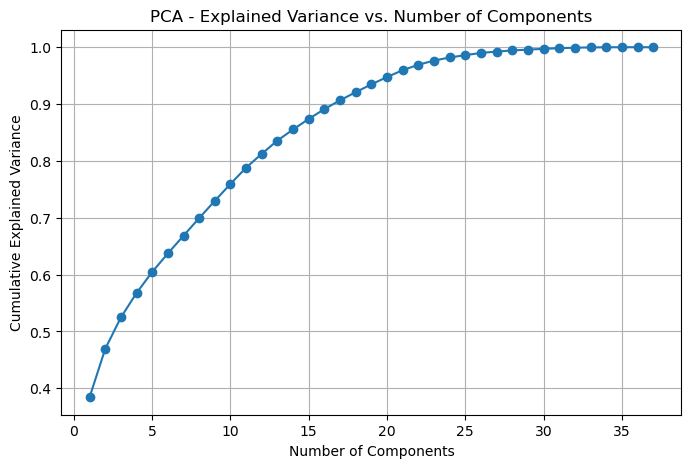

Component 1: 0.3843
Component 2: 0.4694
Component 3: 0.5246
Component 4: 0.5677
Component 5: 0.6047
Component 6: 0.6372
Component 7: 0.6684
Component 8: 0.6994
Component 9: 0.7298
Component 10: 0.7595
Component 11: 0.7882
Component 12: 0.8126
Component 13: 0.8359
Component 14: 0.8553
Component 15: 0.8739
Component 16: 0.8912
Component 17: 0.9067
Component 18: 0.9209
Component 19: 0.9347
Component 20: 0.9475
Component 21: 0.9597
Component 22: 0.9692
Component 23: 0.9765
Component 24: 0.9819
Component 25: 0.9862
Component 26: 0.9899
Component 27: 0.9924
Component 28: 0.9943
Component 29: 0.9958
Component 30: 0.9972
Component 31: 0.9983
Component 32: 0.9992
Component 33: 0.9997
Component 34: 0.9999
Component 35: 1.0000
Component 36: 1.0000
Component 37: 1.0000


In [254]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:39]].dropna()

for i in test_inactive_X.columns[2:39]:
    fix_skew(test_inactive_X, i)

test_inactive_X_scaled = StandardScaler().fit_transform(test_inactive_X)

test_pca = PCA()
test_pca.fit_transform(test_inactive_X_scaled)

explained_variance = test_pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid(True)
plt.show()

for i, var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {var:.4f}")

In [255]:
test_inactive = inactive_data.copy()
test_inactive.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs'], axis=1, inplace=True)

test_active = active_data.copy()
test_active.drop(['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs'], axis=1, inplace=True)

test_inactive_X = test_inactive[test_inactive.columns[2:39]].dropna()
test_active_X = test_active[test_active.columns[2:39]].dropna()

for i in test_inactive_X.columns[2:39]:
    fix_skew(test_inactive_X, i)

for i in test_active_X.columns[2:39]:
    fix_skew(test_active_X, i)

pca = PCA(n_components=13)
inactive_X_pca = pca.fit_transform(test_inactive_X)
active_X_pca = pca.transform(test_active_X)

best_k = find_optimal_clusters(inactive_X_pca)

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(inactive_X_pca)

cluster_probs_inactive = gmm.predict_proba(inactive_X_pca)
cluster_probs_active = gmm.predict_proba(active_X_pca)

Clusters: 2 - Silhouette: 0.476
Clusters: 3 - Silhouette: 0.099
Clusters: 4 - Silhouette: 0.064
Clusters: 5 - Silhouette: 0.009
Clusters: 6 - Silhouette: 0.014
Clusters: 7 - Silhouette: 0.010
Clusters: 8 - Silhouette: -0.031
Optimal cluster count: 2


In [256]:
for i in range(cluster_probs_inactive.shape[1]):
    test_inactive[f'Cluster_{i}_Prob'] = cluster_probs_inactive[:, i]

for i in range(cluster_probs_active.shape[1]):
    test_active[f'Cluster_{i}_Prob'] = cluster_probs_active[:, i]

In [257]:
test_inactive

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status,Cluster_0_Prob,Cluster_1_Prob
0,Adam Jones,ARI,14,33,137,528,485,66,126,84,...,False,False,False,False,False,True,False,retired,1.237568e-03,0.998762
1,Adam Jones,BAL,3,22,132,514,477,61,129,92,...,False,False,False,False,True,False,False,retired,1.339769e-04,0.999866
2,Adam Jones,BAL,4,23,119,519,473,83,131,87,...,False,False,False,False,True,False,False,retired,1.620594e-04,0.999838
3,Adam Jones,BAL,5,24,149,621,581,76,165,116,...,False,False,False,False,True,False,False,retired,7.092527e-10,1.000000
4,Adam Jones,BAL,6,25,151,618,567,68,159,106,...,False,False,False,False,True,False,False,retired,4.802448e-07,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,Édgar Rentería,STL,5,23,150,643,562,94,156,107,...,False,False,True,False,False,False,False,retired,4.624142e-05,0.999954
5208,Édgar Rentería,STL,6,24,141,549,493,54,128,96,...,False,False,True,False,False,False,False,retired,2.309771e-01,0.769023
5209,Édgar Rentería,STL,7,25,152,609,544,77,166,117,...,False,False,True,False,False,False,False,retired,1.018239e-05,0.999990
5210,Édgar Rentería,STL,8,26,157,663,587,96,194,133,...,False,False,True,False,False,False,False,retired,2.008901e-12,1.000000


In [258]:
test_active

,Player,Team,Season,Age,G,PA,AB,R,H,1B,...,Pos_4,Pos_5,Pos_6,Pos_7,Pos_8,Pos_9,Pos_10,status,Cluster_0_Prob,Cluster_1_Prob
0,Christian Yelich,MIA,1,21,62,273,240,34,69,52,...,False,False,False,True,False,False,False,active,9.225599e-01,0.077440
1,Christian Yelich,MIA,2,22,144,660,582,94,165,120,...,False,False,False,True,False,False,False,active,4.785721e-16,1.000000
2,Christian Yelich,MIA,3,23,126,525,476,63,143,104,...,False,False,False,True,False,False,False,active,8.251482e-06,0.999992
3,Christian Yelich,MIA,4,24,155,659,578,78,172,110,...,False,False,False,True,False,False,False,active,2.868717e-13,1.000000
4,Christian Yelich,MIA,5,25,156,695,602,100,170,114,...,False,False,False,False,True,False,False,active,2.800787e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,José Abreu,CHW,5,31,128,553,499,68,132,73,...,False,False,False,False,False,False,False,active,5.911967e-12,1.000000
1770,José Abreu,CHW,6,32,159,693,634,85,180,108,...,False,False,False,False,False,False,False,active,5.940727e-26,1.000000
1771,José Abreu,CHW,7,33,60,262,240,43,76,42,...,False,False,False,False,False,False,False,active,1.496160e-02,0.985038
1772,José Abreu,CHW,8,34,152,659,566,86,148,86,...,False,False,False,False,False,False,False,active,4.360069e-28,1.000000


In [259]:
def calc_bat_avg(hits, at_bats):
    if at_bats == 0:
        return 0.0
    return round((hits/at_bats), 3)

def calc_obp(hits, walks, hbp, at_bats, sf):
    first = hits + walks + hbp
    second = at_bats + hbp + sf
    if second == 0:
        return 0.0
    return round((first/second), 3)

def calc_slug(singles, doubles, triples, hrs, at_bats):
    if at_bats == 0:
        return 0.0
    doubles = doubles * 2
    triples = triples * 3
    home_bs = hrs * 4
    return round(((singles+doubles+triples+home_bs)/at_bats), 3)

def calc_ops(obp, slug):
    return round((obp+slug), 3)

def final_df(df):
    col_names = ['Player',  'Age', 'Season_num', 'G', 'PA', 'AB', 'R', 'H', '1B',
       '2B', '3B', 'HR', 'RBI', 'XBH', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR', 'Pos_1',
       'Pos_2', 'Pos_3', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',
       'Pos_10',  'GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs',
        'Cluster_0_Prob', 'Cluster_1_Prob', 'status']

    empty = []
    for player in df['Player'].unique():
        player_df = df[df['Player'] == player]

        hits = player_df['H'].sum()
        at_bats = player_df['AB'].sum()
        walks = player_df['BB'].sum()
        hbp = player_df['HBP'].sum()
        sf = player_df['SF'].sum()
        singles = player_df['1B'].sum()
        doubles = player_df['2B'].sum()
        triples = player_df['3B'].sum()
        hrs = player_df['HR'].sum()

        obp = calc_obp(hits, walks, hbp, at_bats, sf)
        slg = calc_slug(singles, doubles, triples, hrs, at_bats)

        total_pa = player_df['PA'].sum()
        avg_cluster0 = np.average(player_df['Cluster_0_Prob'], weights=player_df['PA'])
        avg_cluster1 = np.average(player_df['Cluster_1_Prob'], weights=player_df['PA'])

        temp = [player, player_df['Age'].max(), player_df['Season'].nunique(), player_df['G'].sum(),
                total_pa, at_bats, player_df['R'].sum(), hits, singles, doubles, triples, hrs,
                player_df['RBI'].sum(), player_df['XBH'].sum(), player_df['SB'].sum(), player_df['CS'].sum(),
                walks, player_df['SO'].sum(), calc_bat_avg(hits, at_bats), obp, slg, calc_ops(obp, slg),
                player_df['TB'].sum(), player_df['GIDP'].sum(), hbp, player_df['SH'].sum(), sf, 
                player_df['IBB'].sum(), player_df['WAR'].sum(), player_df['Pos_1'].values[0], 
                player_df['Pos_2'].values[0], player_df['Pos_3'].values[0], player_df['Pos_4'].values[0],
                player_df['Pos_5'].values[0], player_df['Pos_6'].values[0], player_df['Pos_7'].values[0],
                player_df['Pos_8'].values[0], player_df['Pos_9'].values[0], player_df['Pos_10'].values[0],
                player_df['GGs'].sum(), player_df['SSs'].sum(), player_df['Bat_Titles'].sum(),
                player_df['All_Stars'].sum(), player_df['MVPs'].sum(), avg_cluster0, avg_cluster1, 
                player_df['status'].unique()[0]]
        empty.append(temp)

    new_df = pd.DataFrame(data=empty, columns=col_names)
    return new_df

In [260]:
awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']
awards_inactive = inactive_data[awards]

final_inactive = pd.concat([test_inactive, awards_inactive], axis=1)
final_inactive = final_df(final_inactive)

awards = ['GGs', 'SSs', 'Bat_Titles', 'All_Stars', 'MVPs']
awards_active = active_data[awards]

final_active = pd.concat([test_active, awards_active], axis=1)
final_active = final_df(final_active)

In [261]:
X = final_inactive.iloc[:, 1:46]
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
y = final_inactive['status'].map({'hof': 1, 'retired': 0})

logistic_lasso = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=10_000).fit(X_scaled, y)

selected_features = X.columns[logistic_lasso.coef_[0] != 0]
print("Selected features:", selected_features)

Selected features: Index(['Age', 'Season_num', 'AB', 'R', '2B', '3B', 'HR', 'RBI', 'XBH', 'SB',
       'CS', 'SO', 'BA', 'OPS', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'WAR',
       'Pos_1', 'Pos_2', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',
       'GGs', 'SSs', 'All_Stars', 'MVPs', 'Cluster_0_Prob', 'Cluster_1_Prob'],
      dtype='object')


In [262]:
print(len(final_inactive.columns[1:46]))
print(len(selected_features))

45
34


In [263]:
corr_mat = final_inactive[selected_features].corr()

corr_check = {}
for i in corr_mat.index:
    for j in corr_mat.columns:
        if corr_mat.loc[i, j] >= 0.7:
            if i != j:
                print(f"{i} + {j}")

Season_num + AB
Season_num + R
AB + Season_num
AB + R
AB + 2B
AB + RBI
AB + XBH
AB + SF
R + Season_num
R + AB
R + 2B
R + RBI
R + XBH
R + WAR
2B + AB
2B + R
2B + RBI
2B + XBH
2B + SF
HR + RBI
HR + XBH
HR + OPS
RBI + AB
RBI + R
RBI + 2B
RBI + HR
RBI + XBH
RBI + OPS
RBI + GIDP
RBI + SF
RBI + IBB
XBH + AB
XBH + R
XBH + 2B
XBH + HR
XBH + RBI
XBH + OPS
XBH + SF
XBH + IBB
XBH + WAR
SB + CS
CS + SB
OPS + HR
OPS + RBI
OPS + XBH
GIDP + RBI
SF + AB
SF + 2B
SF + RBI
SF + XBH
IBB + RBI
IBB + XBH
WAR + R
WAR + XBH
Pos_1 + Cluster_0_Prob
Cluster_0_Prob + Pos_1


In [264]:
to_remove = ['G', 'AB', 'R', 'GIDP', 'XBH', 'SH', 'CS', 'IBB', 'BA', 'OPS']
final_features = ['Player'] + ['PA'] + [i for i in selected_features if i not in to_remove] + ['status']

final_inactive = final_inactive[final_features]
final_active = final_active[final_features]

In [265]:
final_inactive

,Player,PA,Age,Season_num,2B,3B,HR,RBI,SB,SO,...,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,status
0,Adam Jones,7516,33,14,336,29,282,945.0,97.0,1395.0,...,False,False,True,4,1,5,0,0.019666,0.980334,retired
1,Adrian Beltré,12130,39,21,636,38,477,1707.0,121.0,1732.0,...,False,False,False,5,4,4,0,0.062697,0.937303,hof
2,Adrián González,8046,36,15,437,12,317,1202.0,6.0,1401.0,...,False,False,False,4,2,0,0,0.080852,0.919148,retired
3,Al Kaline,11567,39,21,498,75,398,1580.0,136.0,1015.0,...,False,False,True,11,0,5,0,0.096088,0.903912,hof
4,Al Oliver,9498,37,17,518,76,214,1295.0,83.0,732.0,...,False,False,False,0,3,7,0,0.000883,0.999117,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,Yadier Molina,8554,39,19,408,7,176,1022.0,71.0,922.0,...,False,False,False,9,1,7,0,0.152128,0.847872,retired
318,Yogi Berra,8355,38,18,321,49,358,1430.0,30.0,411.0,...,False,False,False,0,0,0,3,0.101512,0.898488,hof
319,Álex Rodríguez,11964,39,21,541,31,687,2055.0,326.0,2220.0,...,False,False,False,1,0,0,0,0.044098,0.955902,retired
320,Álex Ríos,5948,33,10,330,59,152,718.0,233.0,982.0,...,False,True,False,0,0,0,0,0.000102,0.999898,retired


In [266]:
final_active

,Player,PA,Age,Season_num,2B,3B,HR,RBI,SB,SO,...,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,status
0,Christian Yelich,6383,32,12,306,35,204,748,205,1381,...,True,False,False,1,3,3,1,0.068389,9.316105e-01,active
1,Mike Yastrzemski,2581,33,6,134,22,106,318,18,657,...,True,False,False,0,0,0,0,0.085102,9.148980e-01,active
2,Austin Wynns,389,33,4,14,0,8,39,0,82,...,False,False,False,0,0,0,0,1.000000,2.461748e-07,active
3,Jesse Winker,2031,30,6,102,3,80,248,17,357,...,False,False,True,0,0,1,0,0.316550,6.834500e-01,active
4,Taylor Ward,1975,30,5,87,6,70,225,18,446,...,False,False,True,0,0,0,0,0.164763,8.352366e-01,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Nick Ahmed,2824,31,7,140,23,64,294,36,550,...,False,False,False,2,0,0,0,0.247044,7.529559e-01,active
259,Riley Adams,563,28,4,30,4,13,49,1,166,...,False,False,False,0,0,0,0,0.999983,1.660720e-05,active
260,Willy Adames,3610,28,7,172,5,150,472,51,982,...,False,False,False,0,0,0,0,0.056778,9.432223e-01,active
261,Ronald Acuña Jr.,3254,26,7,145,12,165,417,196,719,...,True,False,False,0,3,0,1,0.121687,8.783134e-01,active


In [267]:
def add_rate_stats(df):
    df['HR_per_500_PA'] = (df['HR'] / df['PA']) * 500
    df['Last_3_HR_avg'] = df['HR'].rolling(3).mean()
    df['RBI_per_500_PA'] = (df['RBI'] / df['PA']) * 500
    df['SB_per_500_PA'] = (df['SB'] / df['PA']) * 500
    df['SO_per_500_PA'] = (df['SO'] / df['PA']) * 500
    df['HBP_per_500_PA'] = (df['HBP'] / df['PA']) * 500
    df['SF_per_500_PA'] = (df['SF'] / df['PA']) * 500
    df['WAR_per_500_PA'] = (df['WAR'] / df['PA']) * 500
    df['2B_per_500_PA'] = (df['2B'] / df['PA']) * 500
    df['3B_per_500_PA'] = (df['3B'] / df['PA']) * 500

pa_per = final_inactive['PA'] / final_inactive['Season_num']
print(pa_per.mean())
print(pa_per.median())

504.4746132422857
508.34375


In [268]:
rates_inactive = final_inactive.copy()
add_rate_stats(rates_inactive)

rates_active = final_active.copy()
add_rate_stats(rates_active)

rates_order = ['Player', 'PA', 'Age', 'Season_num', 'Pos_1', 'Pos_2', 'Pos_4', 'Pos_5', 
               'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9', 'Cluster_0_Prob', 'Cluster_1_Prob',
               'HR_per_500_PA', 'RBI_per_500_PA', 'SB_per_500_PA', 'SO_per_500_PA',
                'HBP_per_500_PA', 'SF_per_500_PA', 'WAR_per_500_PA', '2B_per_500_PA',
               '3B_per_500_PA', 'status']

rates_inactive = rates_inactive[rates_order]
rates_active = rates_active[rates_order]

In [269]:
pa_X = rates_inactive[['Age', 'Season_num', 'Pos_1', 'Pos_2', 'Pos_4', 'Pos_5', 'Pos_6', 
                       'Pos_7', 'Pos_8', 'Pos_9', 'Cluster_0_Prob', 'Cluster_1_Prob']]

pa_y = rates_inactive['PA']

pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(pa_X, pa_y, test_size=0.2, random_state=42)

pa_model = XGBRegressor(n_estimators=250, max_depth=4, learning_rate=0.1, n_jobs=-1)

scores = cross_val_score(pa_model, pa_X_train, pa_y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"PA R^2 CV: {scores.mean():.3f} ± {scores.std():.3f}")

pa_model.fit(pa_X_train, pa_y_train)
test_r2 = pa_model.score(pa_X_test, pa_y_test)
print(f"Test R^2 Score: {test_r2}")

PA R^2 CV: 0.800 ± 0.088
Test R^2 Score: 0.7073153257369995


In [291]:
targets = ['2B', '3B', 'HR', 'RBI', 'SB', 'SO','HBP', 'SF', 'WAR']

projections = []
for player in final_active['Player'].unique():
    player_df = final_active[final_active['Player']==player]
    rates_player = rates_active[rates_active['Player']==player]
    
    rates_X = rates_player[['Age', 'Season_num', 'Pos_1', 'Pos_2', 'Pos_4', 'Pos_5', 'Pos_6', 
                       'Pos_7', 'Pos_8', 'Pos_9', 'Cluster_0_Prob', 'Cluster_1_Prob']]

    pred_pa = pa_model.predict(rates_X)
    pred_pa = int(round(pred[0], 0))

    player_proj = [player]
    
    for target in targets:
        curr_val = player_df[target]
        seasons = player_df['Season_num']
        rate_val = rates_player[f"{target}_per_500_PA"]
        total_target = curr_val + (rate_val * (pred_pa/500))
        if target != 'WAR':
            total_target = int(total_target.iloc[0])
        else:
            total_target = round(total_target.iloc[0], 1)
        player_proj.append(total_target)

    player_proj = player_proj + player_df[['Pos_1', 'Pos_2', 'Pos_4', 'Pos_5', 'Pos_6',
                     'Pos_7', 'Pos_8', 'Pos_9', 'GGs', 'SSs', 'All_Stars', 'MVPs',
                     'Cluster_0_Prob', 'Cluster_1_Prob']].iloc[0].tolist()

    projections.append(player_proj)

final_cols = ['Player', '2B', '3B', 'HR', 'RBI', 'SB', 'SO', 'HBP', 'SF', 'WAR',
              'Pos_1', 'Pos_2', 'Pos_4', 'Pos_5', 'Pos_6', 'Pos_7', 'Pos_8', 'Pos_9',
              'GGs', 'SSs', 'All_Stars', 'MVPs', 'Cluster_0_Prob', 'Cluster_1_Prob']

active_projections = pd.DataFrame(data=projections, columns=final_cols)

In [292]:
active_projections

,Player,2B,3B,HR,RBI,SB,SO,HBP,SF,WAR,...,Pos_6,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob
0,Christian Yelich,677,77,451,1656,453,3058,99,57,93.0,...,False,True,False,False,1,3,3,1,0.068389,9.316105e-01
1,Mike Yastrzemski,536,88,424,1273,72,2630,120,56,56.9,...,False,True,False,False,0,0,0,0,0.085102,9.148980e-01
2,Austin Wynns,293,0,167,816,0,1716,83,20,29.3,...,False,False,False,False,0,0,0,0,1.000000,2.461748e-07
3,Jesse Winker,491,14,385,1194,81,1719,163,24,35.2,...,False,False,False,True,0,0,1,0,0.316550,6.834500e-01
4,Taylor Ward,428,29,344,1108,88,2196,123,98,40.4,...,False,False,False,True,0,0,0,0,0.164763,8.352366e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Nick Ahmed,524,86,239,1101,134,2059,52,89,45.3,...,True,False,False,False,2,0,0,0,0.247044,7.529559e-01
259,Riley Adams,443,59,192,723,14,2451,162,44,26.6,...,False,False,False,False,0,0,0,0,0.999983,1.660720e-05
260,Willy Adames,541,15,472,1485,160,3090,37,53,67.0,...,True,False,False,False,0,0,0,0,0.056778,9.432223e-01
261,Ronald Acuña Jr.,490,40,558,1410,662,2432,169,50,86.9,...,False,True,False,False,0,3,0,1,0.121687,8.783134e-01


In [293]:
final_inactive

,Player,PA,Age,Season_num,2B,3B,HR,RBI,SB,SO,...,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,status
0,Adam Jones,7516,33,14,336,29,282,945.0,97.0,1395.0,...,False,False,True,4,1,5,0,0.019666,0.980334,retired
1,Adrian Beltré,12130,39,21,636,38,477,1707.0,121.0,1732.0,...,False,False,False,5,4,4,0,0.062697,0.937303,hof
2,Adrián González,8046,36,15,437,12,317,1202.0,6.0,1401.0,...,False,False,False,4,2,0,0,0.080852,0.919148,retired
3,Al Kaline,11567,39,21,498,75,398,1580.0,136.0,1015.0,...,False,False,True,11,0,5,0,0.096088,0.903912,hof
4,Al Oliver,9498,37,17,518,76,214,1295.0,83.0,732.0,...,False,False,False,0,3,7,0,0.000883,0.999117,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,Yadier Molina,8554,39,19,408,7,176,1022.0,71.0,922.0,...,False,False,False,9,1,7,0,0.152128,0.847872,retired
318,Yogi Berra,8355,38,18,321,49,358,1430.0,30.0,411.0,...,False,False,False,0,0,0,3,0.101512,0.898488,hof
319,Álex Rodríguez,11964,39,21,541,31,687,2055.0,326.0,2220.0,...,False,False,False,1,0,0,0,0.044098,0.955902,retired
320,Álex Ríos,5948,33,10,330,59,152,718.0,233.0,982.0,...,False,True,False,0,0,0,0,0.000102,0.999898,retired


In [294]:
final_inactive_X = final_inactive.iloc[:, 4:27]
scaler = StandardScaler()

final_inactive_X_scaled = scaler.fit_transform(final_inactive_X)
y = final_inactive['status'].map({'hof': 1, 'retired': 0})

hof_pipeline = make_pipeline(
    BorderlineSMOTE(sampling_strategy='auto', kind='borderline-1'),
    RandomForestClassifier(class_weight='balanced')
)

skf = StratifiedKFold(n_splits=5)
for train_idx, test_idx in skf.split(final_inactive_X, y):
    X_train, X_test = final_inactive_X.iloc[train_idx], final_inactive_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    hof_pipeline.fit(X_train, y_train)
    y_pred = hof_pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91        48
           1       0.74      0.82      0.78        17

    accuracy                           0.88        65
   macro avg       0.84      0.86      0.85        65
weighted avg       0.88      0.88      0.88        65

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        48
           1       0.80      0.71      0.75        17

    accuracy                           0.88        65
   macro avg       0.85      0.82      0.83        65
weighted avg       0.87      0.88      0.87        65

              precision    recall  f1-score   support

           0       0.91      0.90      0.91        48
           1       0.71      0.75      0.73        16

    accuracy                           0.86        64
   macro avg       0.81      0.82      0.82        64
weighted avg       0.86      0.86      0.86        64

              preci

In [295]:
active_probs = hof_pipeline.predict_proba(active_projections.iloc[:,1:])
active_projections['hof_probability'] = active_probs[:, 1]

In [298]:
active_projections[active_projections['hof_probability'] >= 0.65]

,Player,2B,3B,HR,RBI,SB,SO,HBP,SF,WAR,...,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,hof_probability
0,Christian Yelich,677,77,451,1656,453,3058,99,57,93.0,...,True,False,False,1,3,3,1,6.838946e-02,0.931611,0.71
18,Trea Turner,642,104,437,1464,714,2358,92,48,93.2,...,False,False,False,0,1,3,0,3.846758e-02,0.961532,0.69
34,Fernando Tatis Jr.,484,44,565,1432,409,2495,97,53,94.3,...,False,False,False,0,0,0,0,8.025747e-03,0.991974,0.72
35,Dansby Swanson,552,46,389,1470,241,2900,75,78,70.0,...,False,False,False,2,0,1,0,5.367157e-02,0.946328,0.70
45,George Springer,519,51,610,1665,238,2816,180,70,87.7,...,False,False,True,0,2,3,0,3.565176e-02,0.964348,0.81
46,Juan Soto,518,43,582,1714,165,2015,46,57,105.4,...,True,False,False,0,4,4,0,4.789290e-02,0.952107,0.84
70,Austin Riley,526,32,514,1430,20,2537,174,101,87.6,...,False,False,False,0,2,2,0,1.131349e-09,1.000000,0.69
71,Bryan Reynolds,520,86,404,1363,126,2428,152,59,65.3,...,True,False,False,0,0,2,0,6.216038e-02,0.937840,0.74
76,J.T. Realmuto,645,86,428,1595,245,2673,186,89,92.7,...,False,False,False,2,3,3,0,4.499378e-02,0.955006,0.73
89,Shohei Ohtani,526,113,709,1787,457,2890,69,56,90.5,...,False,False,False,0,3,4,3,4.858414e-02,0.951416,0.76


In [299]:
active_projections[active_projections['Player']=='Manny Machado']

,Player,2B,3B,HR,RBI,SB,SO,HBP,SF,WAR,...,Pos_7,Pos_8,Pos_9,GGs,SSs,All_Stars,MVPs,Cluster_0_Prob,Cluster_1_Prob,hof_probability
126,Manny Machado,737,36,694,2130,201,2644,54,119,117.4,...,False,False,False,2,2,6,0,0.05655,0.94345,0.58
